In [1]:
%env AWS_ACCESS_KEY_ID=projet-slums-sa
%env AWS_SECRET_ACCESS_KEY=hB2N6hCmp7JoFA6WHKT022WJ9lOc1oOr

env: AWS_ACCESS_KEY_ID=projet-slums-sa
env: AWS_SECRET_ACCESS_KEY=hB2N6hCmp7JoFA6WHKT022WJ9lOc1oOr


In [2]:
import sys
sys.path.append('../src')
import shutil
import yaml
import py7zr
import os
import s3fs
from satellite_image import SatelliteImage
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import rasterio.plot as rp
import re
from datetime import datetime

In [ ]:
from utils import get_root_path

with open("../environment.yml") as f:
    environment = yaml.safe_load(f)

root_path = get_root_path()
bucket = environment["bucket"]
path_s3_cayenne_data = environment["sources"]["cayenne"]
path_local_cayenne_data = os.path.join(root_path, environment["local-path"]["cayenne"])

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
fs.get(f"{bucket}/{path_s3_cayenne_data}", f"{path_local_cayenne_data}")
with py7zr.SevenZipFile(f"{path_local_cayenne_data}", mode="r") as z:
    z.extractall()

shutil.move(
    os.path.splitext(os.path.basename(path_s3_cayenne_data))[0],
    os.path.splitext(path_local_cayenne_data)[0],
)


In [3]:
filename = '../data/Cayenne/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')

In [4]:
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4
    )

In [5]:
list_images = image.split(256)

In [6]:
list_images[0].normalize()

Text(0, 0.5, 'Pixels Lignes')

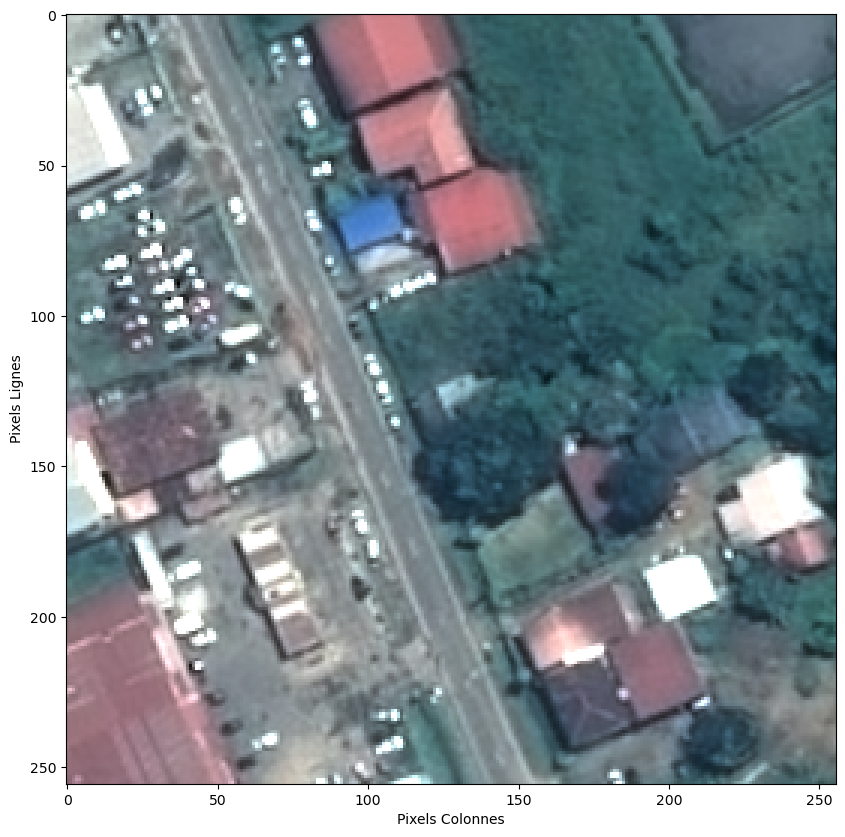

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(list_images[0].array, (1, 2, 0))[:,:,:3])
plt.xlabel('Pixels Colonnes')
plt.ylabel('Pixels Lignes')

In [8]:
from labeler import RILLabeler
from labeled_satellite_image import SegmentationLabeledSatelliteImage

labeler = RILLabeler(date)

In [9]:
mask = labeler.create_segmentation_label(image)

/opt/mamba/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Warning to remove

In [10]:
image.array.shape

(4, 2000, 2000)

In [11]:
image.normalize()

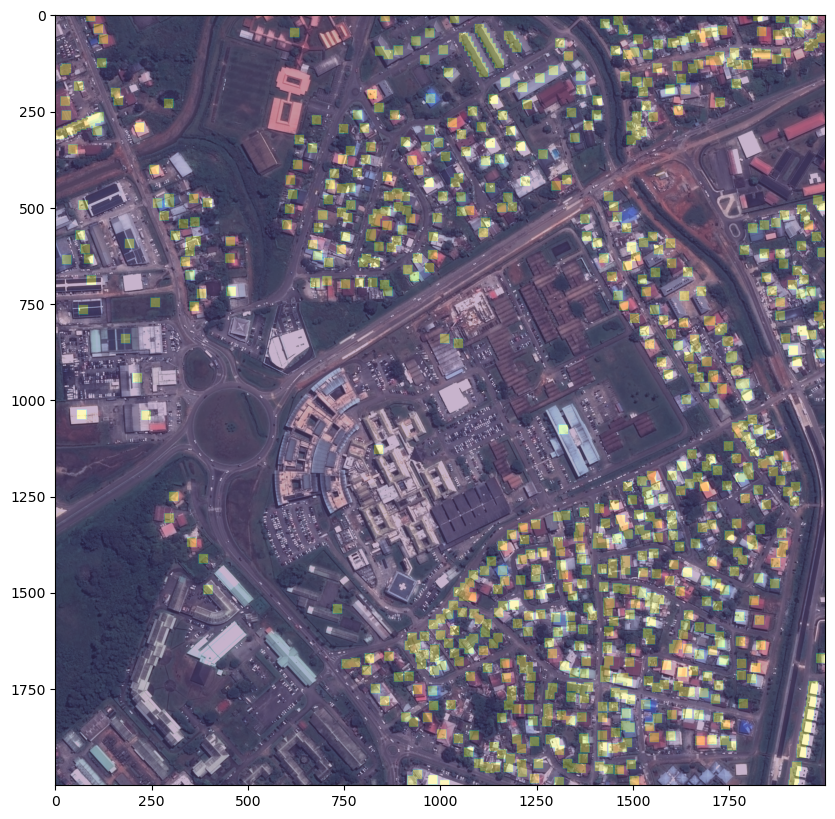

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
ax.imshow(mask, alpha=0.3)

C'est le même résultat que dans le notebook de Clément

In [13]:
from labeled_satellite_image import DetectionLabeledSatelliteImage
label = labeler.create_detection_label(image)

/opt/mamba/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
label

[(80.0, 0.0, 105.0, 17.0),
 (100.0, 23.0, 125.0, 48.0),
 (610.0, 33.0, 635.0, 58.0),
 (113.0, 50.0, 138.0, 75.0),
 (109.0, 112.0, 134.0, 137.0),
 (13.0, 126.0, 42.0, 156.0),
 (49.0, 172.0, 74.0, 197.0),
 (145.0, 189.0, 177.0, 235.0),
 (14.0, 211.0, 39.0, 236.0),
 (283.0, 217.0, 308.0, 242.0),
 (845.0, 0.0, 870.0, 17.0),
 (961.0, 34.0, 986.0, 59.0),
 (925.0, 55.0, 950.0, 80.0),
 (879.0, 79.0, 904.0, 104.0),
 (831.0, 81.0, 878.0, 115.0),
 (948.0, 104.0, 973.0, 129.0),
 (811.0, 193.0, 836.0, 218.0),
 (963.0, 204.0, 988.0, 229.0),
 (829.0, 228.0, 854.0, 253.0),
 (870.0, 247.0, 895.0, 272.0),
 (773.0, 247.0, 798.0, 272.0),
 (791.0, 281.0, 816.0, 306.0),
 (737.0, 283.0, 762.0, 308.0),
 (961.0, 286.0, 986.0, 311.0),
 (898.0, 317.0, 923.0, 342.0),
 (951.0, 329.0, 976.0, 354.0),
 (808.0, 330.0, 833.0, 355.0),
 (735.0, 340.0, 780.0, 387.0),
 (795.0, 363.0, 820.0, 388.0),
 (915.0, 365.0, 940.0, 390.0),
 (1019.0, 267.0, 1044.0, 292.0),
 (1095.0, 278.0, 1120.0, 303.0),
 (1171.0, 288.0, 1196.0, 313.

In [19]:
len(label)

513

In [17]:
from shapely.geometry import box
import geopandas as gpd

boxes = []
for bounding_coordinates in label:
    boxes.append(box(*bounding_coordinates))
g = gpd.GeoSeries(boxes)
g

0      POLYGON ((105.000 0.000, 105.000 17.000, 80.00...
1      POLYGON ((125.000 23.000, 125.000 48.000, 100....
2      POLYGON ((635.000 33.000, 635.000 58.000, 610....
3      POLYGON ((138.000 50.000, 138.000 75.000, 113....
4      POLYGON ((134.000 112.000, 134.000 137.000, 10...
                             ...                        
508    POLYGON ((1268.000 1932.000, 1268.000 1957.000...
509    POLYGON ((1379.000 1932.000, 1379.000 1969.000...
510    POLYGON ((1226.000 1933.000, 1226.000 1979.000...
511    POLYGON ((1258.000 1971.000, 1258.000 1996.000...
512    POLYGON ((1322.000 1979.000, 1322.000 2000.000...
Length: 513, dtype: geometry

<AxesSubplot: >

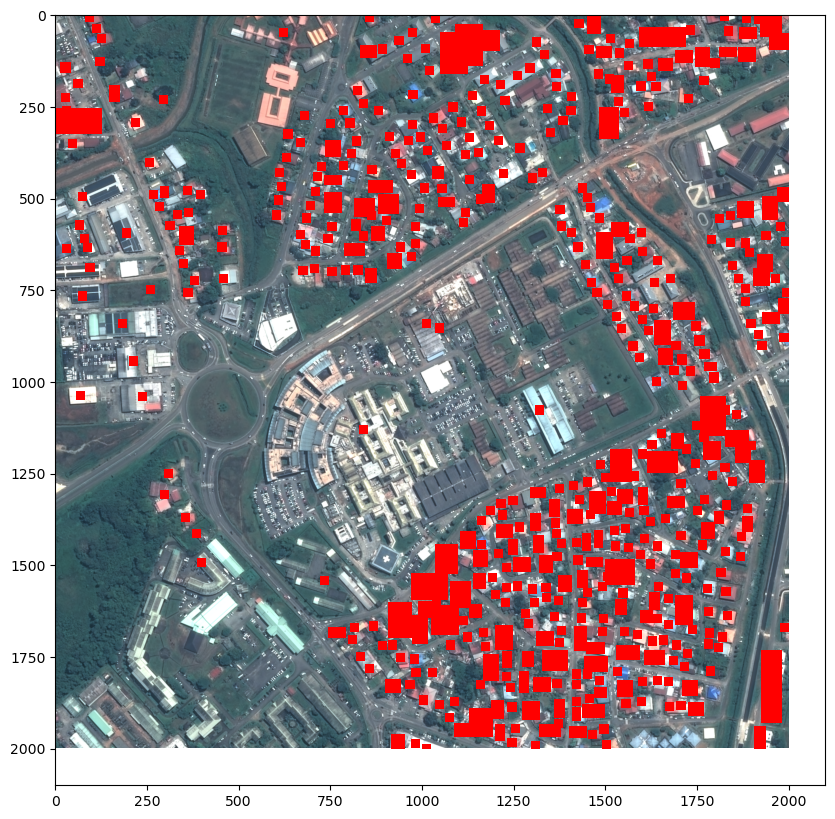

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
g.plot(color="red", ax=ax)